In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import Sequential, layers
from keras.layers import Dense, Dropout
from pickle import load

In [2]:
# raw_data = pd.read_csv(r"../data/processed_data/undersampled_train.csv", index_col=0)
raw_data = pd.read_csv(r"../data/processed_data/oversampled_train.csv", index_col=0)

In [3]:
x = raw_data.drop(["TARGET"], axis=1)
y = raw_data.filter(["TARGET"], axis=1)

scaler = scaler = load(open(r"scaler.pkl", "rb"))  # MinMaxScaler often made values = 0.0, which = lost features in training
x_scaled = scaler.transform(x)
y = y.values  # we dont need to scale our binary classification

# x_scaled = x_scaled.reshape(x_scaled.shape[0], x_scaled.shape[1], )  # data needs to be 3D for a CNN

x_scaled.shape, y.shape

((480566, 120), (480566, 1))

In [4]:
def model_builder(hp):
    model = Sequential()

    # input layer
    model.add(Dense(units=x_scaled.shape[1], input_shape=(x_scaled.shape[1],)))

    # let the model decide how many layers it wants to have
    for i in range(hp.Int("num_dense_layers", min_value=2, max_value=5, step=1)):
        model.add(
            Dropout(hp.Float("dropout_" + str(i), min_value=0, max_value=0.5, step=0.1))
        )
        model.add(
            Dense(
                units=hp.Int("layer_" + str(i), min_value=32, max_value=1024, step=64),
                activation=hp.Choice("act_" + str(i), ["relu", "sigmoid"]),
            )
        )

    # output shape of the model the same as the number of features
    model.add(
        Dense((1), activation="sigmoid"),
    )

    # compile the model
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(), "accuracy"],
    )

    return model


In [5]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=2)

In [7]:
project = "BayOpt_v1.03"

tuner = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective("accuracy", direction="max"),
    max_trials=20, # I could stop it earlier, or even let it run forever but, my computer isn't powerful enough
    directory=f"../logs/oversampled/{project}",
    project_name=project,
)


INFO:tensorflow:Reloading Tuner from ../logs/oversampled/BayOpt_v1.03\BayOpt_v1.03\tuner0.json


In [8]:
tuner.search(
    x_scaled,
    y,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[earlyStop],
)


Trial 20 Complete [00h 10m 02s]
accuracy: 0.894738495349884

Best accuracy So Far: 0.9125456213951111
Total elapsed time: 01h 35m 46s
INFO:tensorflow:Oracle triggered exit


In [9]:
hpModel = tuner.get_best_models()[0]
hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

hpModel.summary(), hyperparameters.values

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               14520     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 544)               65824     
                                                                 
 dropout_1 (Dropout)         (None, 544)               0         
                                                                 
 dense_2 (Dense)             (None, 544)               296480    
                                                                 
 dense_3 (Dense)             (None, 1)                 545       
                                                                 
Total params: 377,369
Trainable params: 377,369
Non-trai

(None,
 {'num_dense_layers': 2,
  'dropout_0': 0.0,
  'layer_0': 544,
  'act_0': 'relu',
  'dropout_1': 0.30000000000000004,
  'layer_1': 544,
  'act_1': 'relu',
  'learning_rate': 0.001,
  'dropout_2': 0.0,
  'layer_2': 800,
  'act_2': 'sigmoid',
  'dropout_3': 0.2,
  'layer_3': 672,
  'act_3': 'sigmoid',
  'dropout_4': 0.0,
  'layer_4': 32,
  'act_4': 'sigmoid'})

In [11]:
trained_model = hpModel.fit(
    x_scaled, y, epochs=10, batch_size=32, callbacks=earlyStop
)

Epoch 1/10
15018/15018 [==============================] - 90s 6ms/step - loss: 0.2288 - auc: 0.9600 - accuracy: 0.9093
Epoch 2/10
15018/15018 [==============================] - 88s 6ms/step - loss: 0.2253 - auc: 0.9612 - accuracy: 0.9113
Epoch 3/10
15018/15018 [==============================] - 83s 6ms/step - loss: 0.2250 - auc: 0.9621 - accuracy: 0.9133
Epoch 4/10
15018/15018 [==============================] - 82s 5ms/step - loss: 0.2193 - auc: 0.9626 - accuracy: 0.9144
Epoch 5/10
15018/15018 [==============================] - 83s 5ms/step - loss: 0.2173 - auc: 0.9632 - accuracy: 0.9160
Epoch 6/10
15018/15018 [==============================] - 83s 6ms/step - loss: 0.2156 - auc: 0.9634 - accuracy: 0.9165
Epoch 7/10
15018/15018 [==============================] - 83s 6ms/step - loss: 0.2160 - auc: 0.9635 - accuracy: 0.9168
Epoch 8/10
15018/15018 [==============================] - 83s 6ms/step - loss: 0.2189 - auc: 0.9639 - accuracy: 0.9178
Epoch 9/10
15018/15018 [========================

In [21]:
hpModel.save(f"neural_network/{project}")

INFO:tensorflow:Assets written to: neural_network/BayOpt_v1.03\assets


In [22]:
model_performance = hpModel.evaluate(x_scaled, y)
print(f"Loss: {model_performance[0]}\nAccuracy: {model_performance[1]}")

15018/15018 [==============================] - 43s 3ms/step - loss: 0.2027 - auc: 0.9682 - accuracy: 0.9221
Loss: 0.20271925628185272
Accuracy: 0.968172013759613


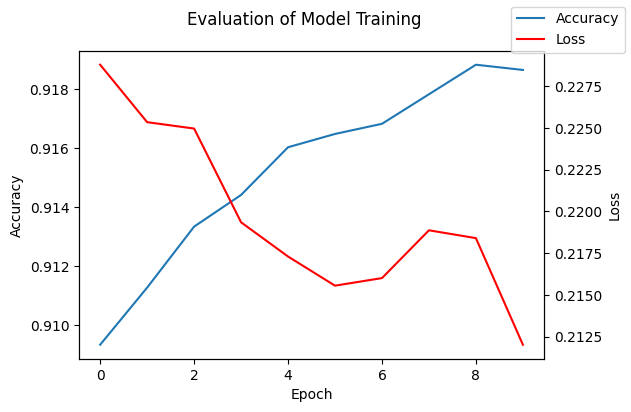

In [23]:
fig, (ax1) = plt.subplots(figsize=(6, 4))
fig.suptitle("Evaluation of Model Training")
ax2 = ax1.twinx()

ax1.plot(trained_model.history["accuracy"], label="Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(trained_model.history["loss"], color="r", label="Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")

fig.legend()